## Using pre-trained models for Texture Classification
In this lab, we will use pre-trained models for the same texture classification task. The dataset we will be using is available here: http://dx.doi.org/10.5281/zenodo.53169. 

![alt text](https://www.researchgate.net/profile/Jakob_Kather/publication/303998214/figure/fig7/AS:391073710002224@1470250646407/Representative-images-from-our-dataset-Here-the-first-10-images-of-every-tissue-class.png)

The above figure shows the 8 different classes of tissue we will be trying to identify. 

In [0]:
from __future__ import print_function
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from matplotlib import pylab as plt
from skimage.color import rgb2lab, rgb2hsv

## Step 1: Load pre-trained VGG16 model
We will use the VGG16 model as the feature extractor for this classification task. First, we need to download the pre-trained weights. The model has been trained on the ImageNet image classification dataset. For more details on this dataset see http://www.image-net.org/. 

In [2]:
model = None
model = VGG16(weights='imagenet', include_top=False, input_shape = (150, 150, 3))
#model.summary()

58900480/58889256 [==============================] - 1s 0us/step


## VGG16
Let's examine the VGG16 model. The model has 16 layers as seen above. The model has the following specifications
* Expected input size : 224x224 pixels
* Number of output classes : 1000

Our images are 150x150 pixels in size and come from only 10 categories. In order to use this model for our classification task, we need to do the following:
* Resize images : Our input images can be resized to the appropriate dimensions. Alternatively, we can pad our images to the expected dimensions. Padding leads to additional choices - Do we pad with zeros, duplicate edge pixels or mirror the image across edges ?
* Change the prediction layer : Remove the existing prediction layer and add a new layer that can predict 8 classes.
* Train : Finally, we need to train the network on our data

# Step 2
Load the data and resize images appropriately. Use the helper function in utils.py. The assumption is that you have already cloned the Week3 repo and know the path to the data folder.

In [0]:
def load_crc_data(data_dir):
    y = np.load(os.path.join(data_dir, 'rgb01.npz'))
    labels = y['labels']
    data = y['rgb_data']
    label_str = y['label_str']
    label_str = label_str.tolist() # this is to convert label_str back to a dictionary
    y = []

    for ii in range(2,6):
        filename = os.path.join(data_dir, 'rgb0' + str(ii) + '.npz')
        print('loading ', filename)
        y = np.load(filename)
        labels = np.append(labels, y['labels'], axis=0)
        data = np.append(data, y['rgb_data'], axis=0)
        print(data.shape)

    return data, labels, label_str

In [5]:
#! git clone https://github.com/BeaverWorksMedlytics/Week3_public.git
os.chdir('..')
from skimage.transform import resize
from sklearn.model_selection import train_test_split
data_dir = os.path.join( os.getcwd(), 'Week3_public', 'data', 'crc')
data, labels, label_str = load_crc_data(data_dir)
num_images = data.shape[0]

Cloning into 'Week3_public'...
remote: Counting objects: 82, done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82
Unpacking objects: 100% (82/82), done.
Checking out files: 100% (25/25), done.
loading  /Week3_public/data/crc/rgb02.npz
(2000, 150, 150, 3)
loading  /Week3_public/data/crc/rgb03.npz
(3000, 150, 150, 3)
loading  /Week3_public/data/crc/rgb04.npz
(4000, 150, 150, 3)
loading  /Week3_public/data/crc/rgb05.npz
(5000, 150, 150, 3)


In [0]:
# Resize data
#resized_data = np.zeros((num_images, 224, 224, 3))
#for ii in range(0, num_images):
#    resized_data[ii,::] = resize(data[ii,::], (224, 224, 3), mode='symmetric')
#data = resized_data
#resized_data = []
#print(data.shape)

(5000, 224, 224, 3)


In [0]:
#with open('resized.npz', 'wb') as fp:
#    np.savez(fp, data=data, labels=labels)

In [0]:
# Split data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=.2)
data = None
ntrain = train_images.shape[0]
ntest  = test_images.shape[0]

## Step 3
We will now modify the pre-trained VGG network as described earlier. We will remove the following layers : 

<img src="images/final_layers.png" width="65%"></img> 


In [7]:
# remove the final layer in the model
for ii in range(0,4):
    model.layers.pop()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [8]:
# Convert into sequential
seq_model = None
seq_model = Sequential()
for layer in model.layers:
    seq_model.add( layer )
seq_model.summary()

for ii in range(0,1):
    seq_model.pop()

seq_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
__________

# Step 4
Freeze the layers that remain in our model.

In [9]:
for layer in seq_model.layers:
    layer.trainable = False
seq_model.summary()

seq_model.add( Flatten(name="my_flatten") )
#seq_model.add( Dense(1024, activation="relu", name="new_dense1") )
#seq_model.add( Dropout(0.5) )
#seq_model.add( Dense(64, activation="relu", name="new_dense2") )
seq_model.add( Dense(8, activation="relu", name="predictions") )

seq_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
__________

In [0]:
seq_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics = ['accuracy'])

In [0]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [13]:
y = seq_model.fit(train_images, train_labels, validation_data=(test_images, test_labels),
                  batch_size=64, epochs=50, verbose=1)

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 25s 6ms/step - loss: 3.3348 - acc: 0.2885 - val_loss: 3.2225 - val_acc: 0.5120
Epoch 2/50
4000/4000 [==============================] - 22s 5ms/step - loss: 2.9779 - acc: 0.5660 - val_loss: 2.9947 - val_acc: 0.5650
Epoch 3/50
4000/4000 [==============================] - 22s 6ms/step - loss: 2.9329 - acc: 0.4103 - val_loss: 2.7983 - val_acc: 0.5120
Epoch 4/50
4000/4000 [==============================] - 22s 6ms/step - loss: 3.3968 - acc: 0.3535 - val_loss: 3.6540 - val_acc: 0.2610
Epoch 5/50
1088/4000 [=======>......................] - ETA: 12s - loss: 3.5454 - acc: 0.2270

4000/4000 [==============================] - 22s 6ms/step - loss: 3.5338 - acc: 0.2402 - val_loss: 3.5356 - val_acc: 0.2630
Epoch 6/50
4000/4000 [==============================] - 22s 6ms/step - loss: 3.4470 - acc: 0.2420 - val_loss: 3.4717 - val_acc: 0.2640
Epoch 7/50
4000/4000 [==============================] - 22s 6ms/step - loss: 3.3917 - acc: 0.2435 - val_loss: 3.4238 - val_acc: 0.2650
Epoch 8/50
4000/4000 [==============================] - 22s 6ms/step - loss: 3.3478 - acc: 0.2442 - val_loss: 3.3834 - val_acc: 0.2650
Epoch 9/50
2880/4000 [====================>.........] - ETA: 4s - loss: 3.3463 - acc: 0.2344

4000/4000 [==============================] - 22s 6ms/step - loss: 3.3096 - acc: 0.2445 - val_loss: 3.3469 - val_acc: 0.2650
Epoch 10/50
4000/4000 [==============================] - 22s 6ms/step - loss: 3.2751 - acc: 0.2447 - val_loss: 3.3134 - val_acc: 0.2650
Epoch 11/50
4000/4000 [==============================] - 22s 6ms/step - loss: 3.2427 - acc: 0.2452 - val_loss: 3.2812 - val_acc: 0.2650
Epoch 12/50
4000/4000 [==============================] - 22s 6ms/step - loss: 3.2114 - acc: 0.2452 - val_loss: 3.2494 - val_acc: 0.2680
Epoch 13/50
3072/4000 [======================>.......] - ETA: 4s - loss: 3.2735 - acc: 0.2503

4000/4000 [==============================] - 22s 6ms/step - loss: 3.1808 - acc: 0.2470 - val_loss: 3.2197 - val_acc: 0.2740
Epoch 14/50
4000/4000 [==============================] - 22s 6ms/step - loss: 3.1534 - acc: 0.2542 - val_loss: 3.1942 - val_acc: 0.2820
Epoch 15/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.8684 - acc: 0.2632 - val_loss: 1.4687 - val_acc: 0.2930
Epoch 16/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.4663 - acc: 0.2780 - val_loss: 1.4237 - val_acc: 0.3040
Epoch 17/50
3072/4000 [======================>.......] - ETA: 4s - loss: 1.4290 - acc: 0.2923

4000/4000 [==============================] - 22s 6ms/step - loss: 1.4274 - acc: 0.2935 - val_loss: 1.3871 - val_acc: 0.3200
Epoch 18/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.3920 - acc: 0.3095 - val_loss: 1.3514 - val_acc: 0.3470
Epoch 19/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.3560 - acc: 0.3270 - val_loss: 1.3146 - val_acc: 0.3640
Epoch 20/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.3175 - acc: 0.3498 - val_loss: 1.2751 - val_acc: 0.3840
Epoch 21/50
3072/4000 [======================>.......] - ETA: 4s - loss: 1.2725 - acc: 0.3818

4000/4000 [==============================] - 22s 6ms/step - loss: 1.2754 - acc: 0.3790 - val_loss: 1.2314 - val_acc: 0.4170
Epoch 22/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.2270 - acc: 0.4143 - val_loss: 1.1811 - val_acc: 0.4510
Epoch 23/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.1693 - acc: 0.4602 - val_loss: 1.1202 - val_acc: 0.5090
Epoch 24/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.0938 - acc: 0.5300 - val_loss: 1.0495 - val_acc: 0.5690
Epoch 25/50
3072/4000 [======================>.......] - ETA: 4s - loss: 0.9979 - acc: 0.6035

4000/4000 [==============================] - 22s 6ms/step - loss: 0.9798 - acc: 0.6110 - val_loss: 0.9312 - val_acc: 0.6520
Epoch 26/50
4000/4000 [==============================] - 22s 6ms/step - loss: 0.8509 - acc: 0.6733 - val_loss: 0.8159 - val_acc: 0.6930
Epoch 27/50
4000/4000 [==============================] - 22s 6ms/step - loss: 0.8074 - acc: 0.6613 - val_loss: 0.8573 - val_acc: 0.6590
Epoch 28/50
4000/4000 [==============================] - 22s 6ms/step - loss: 0.7213 - acc: 0.7122 - val_loss: 0.9197 - val_acc: 0.7160
Epoch 29/50
3072/4000 [======================>.......] - ETA: 4s - loss: 0.6829 - acc: 0.7682

4000/4000 [==============================] - 22s 6ms/step - loss: 0.6985 - acc: 0.7740 - val_loss: 1.1818 - val_acc: 0.7600
Epoch 30/50
4000/4000 [==============================] - 22s 6ms/step - loss: 0.7042 - acc: 0.8060 - val_loss: 1.2259 - val_acc: 0.7630
Epoch 31/50
4000/4000 [==============================] - 22s 6ms/step - loss: 0.6052 - acc: 0.8197 - val_loss: 1.4639 - val_acc: 0.7450
Epoch 32/50
4000/4000 [==============================] - 22s 6ms/step - loss: 0.5950 - acc: 0.8195 - val_loss: 1.1212 - val_acc: 0.7470
Epoch 33/50
3072/4000 [======================>.......] - ETA: 4s - loss: 1.1243 - acc: 0.6107

4000/4000 [==============================] - 22s 6ms/step - loss: 1.4177 - acc: 0.4952 - val_loss: 2.3082 - val_acc: 0.1190
Epoch 34/50
4000/4000 [==============================] - 22s 6ms/step - loss: 2.1323 - acc: 0.1298 - val_loss: 2.0650 - val_acc: 0.1270
Epoch 35/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.9956 - acc: 0.1430 - val_loss: 1.9630 - val_acc: 0.1460
Epoch 36/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.9204 - acc: 0.1618 - val_loss: 1.8968 - val_acc: 0.1730
Epoch 37/50
3072/4000 [======================>.......] - ETA: 4s - loss: 1.8712 - acc: 0.1794

4000/4000 [==============================] - 22s 6ms/step - loss: 1.8648 - acc: 0.1822 - val_loss: 1.8470 - val_acc: 0.2010
Epoch 38/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.8234 - acc: 0.2013 - val_loss: 1.8064 - val_acc: 0.2260
Epoch 39/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.7889 - acc: 0.2165 - val_loss: 1.7715 - val_acc: 0.2430
Epoch 40/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.7589 - acc: 0.2243 - val_loss: 1.7410 - val_acc: 0.2510
Epoch 41/50
3072/4000 [======================>.......] - ETA: 4s - loss: 1.7314 - acc: 0.2314

4000/4000 [==============================] - 22s 6ms/step - loss: 1.7330 - acc: 0.2308 - val_loss: 1.7148 - val_acc: 0.2570
Epoch 42/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.7104 - acc: 0.2357 - val_loss: 1.6918 - val_acc: 0.2610
Epoch 43/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.6901 - acc: 0.2380 - val_loss: 1.6708 - val_acc: 0.2620
Epoch 44/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.6713 - acc: 0.2400 - val_loss: 1.6510 - val_acc: 0.2630
Epoch 45/50
3072/4000 [======================>.......] - ETA: 4s - loss: 1.6463 - acc: 0.2451

4000/4000 [==============================] - 22s 6ms/step - loss: 1.6534 - acc: 0.2415 - val_loss: 1.6321 - val_acc: 0.2640
Epoch 46/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.6362 - acc: 0.2422 - val_loss: 1.6138 - val_acc: 0.2640
Epoch 47/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.6195 - acc: 0.2435 - val_loss: 1.5960 - val_acc: 0.2660
Epoch 48/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.6031 - acc: 0.2442 - val_loss: 1.5782 - val_acc: 0.2680
Epoch 49/50
3072/4000 [======================>.......] - ETA: 4s - loss: 1.5897 - acc: 0.2454

4000/4000 [==============================] - 22s 6ms/step - loss: 1.5868 - acc: 0.2462 - val_loss: 1.5606 - val_acc: 0.2700
Epoch 50/50
4000/4000 [==============================] - 22s 6ms/step - loss: 1.5712 - acc: 0.2492 - val_loss: 1.5443 - val_acc: 0.2730


['acc', 'loss', 'val_acc', 'val_loss']


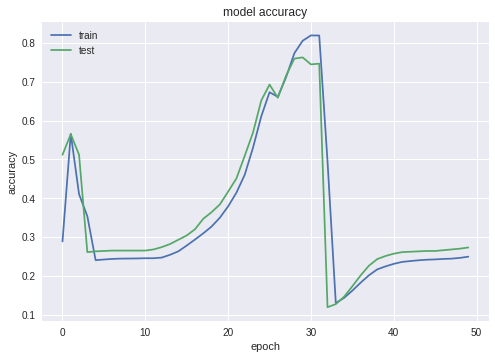

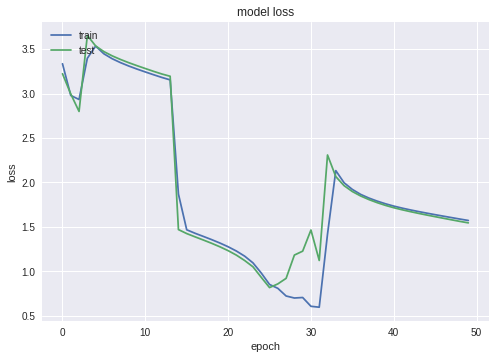

In [14]:
print(y.history.keys())
# summarize history for accuracy
plt.plot(y.history['acc'])
plt.plot(y.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(y.history['loss'])
plt.plot(y.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# convert images to LAB space and normalize

lab_train = np.zeros((ntrain, 224, 224, 3))
ii = 0
for im in train_images:
    lab_train[ii,::] = rgb2lab(im)
    ii = ii + 1
    # normalize ?

In [0]:
k = 1000
plt.figure(figsize=(40,20))
plt.subplot(2,4,1)
plt.imshow(train_images[k,::])
plt.axis('off')
for ii in range(0,3):
    plt.subplot(2,4,ii+2)
    plt.imshow(lab_train[k,:,:,ii])
    plt.gray()
    plt.axis('off')
im = train_images[k,::]
hsvim = rgb2hsv(im)
plt.subplot(2,4,6)
plt.imshow(hsvim[:,:,0])
plt.axis('off')
plt.subplot(2,4,7)
plt.imshow(hsvim[:,:,1])
plt.axis('off')
plt.subplot(2,4,8)
plt.imshow(hsvim[:,:,2])
plt.axis('off')
plt.show()